
# Solar Energy Forecasting: LSTM-Attention Model for PV Panel Performance Prediction.

This notebook implements a machine learning pipeline for forecasting solar panel temperature and power output using LSTM neural networks with attention mechanisms.

----

**Dataset Source:**

- Desert Knowledge Australia Solar Centre (DKASC)

- *Location*: Alice Springs, Northern Territory, Australia


----

**Team**: IOT-Project-Group7

**Course**: AAI530 - IoT and Machine Learning

**Institution**: University of San Diego (USD)

**Date**: February 2026

In [ ]:
# Import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda, Attention
import random
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import CSVLogger

In [ ]:
# Data Loading
# Load the DKASC dataset containing 5-minute interval sensor measurements
# from Solar Centre CA-PV1 site

df = pd.read_csv('/IOT-Project-Group7/Data/8-Site_CA-PV1-DB-CA-1A.csv')
df.head()

,timestamp,Current_Phase_Average_Mean,Active_Energy_Delivered_Received,Active_Power,Wind_Speed,Weather_Temperature_Celsius,Global_Horizontal_Radiation,Wind_Direction,Weather_Daily_Rainfall,Max_Wind_Speed,Air_Pressure,Hail_Accumulation,Pyranometer_1,Temperature_Probe_1,Temperature_Probe_2
0,2016-04-01 23:45:00,0.698190,13641.339844,-0.039533,1.386667,21.733334,-3.157586,228.800003,0.0,2.0,957.099976,0.0,99999.898438,37.152992,37.188801
1,2016-04-01 23:50:00,0.698110,13641.336914,-0.039693,1.096667,21.523333,-3.060027,249.133331,0.0,2.0,957.099976,0.0,99999.898438,92.096169,37.268780
2,2016-04-01 23:55:00,0.698238,13641.333008,-0.039624,0.420000,21.606667,-3.305817,151.133331,0.0,1.4,957.099976,0.0,99999.898438,55.639309,37.327877
3,2016-04-02 00:00:00,0.698065,13641.330078,-0.039585,0.506667,21.753334,-3.252611,233.600006,0.0,1.3,957.079956,0.0,99999.898438,37.357906,37.340668
4,2016-04-02 00:00:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Data Shape Inspection
# Verify dataset dimensions: (rows, columns)

df.shape

(1018725, 15)

In [ ]:
# Column Names Inspection
# Display all columns in the dataset for reference

df.columns

Index(['timestamp', 'Current_Phase_Average_Mean',
       'Active_Energy_Delivered_Received', 'Active_Power', 'Wind_Speed',
       'Weather_Temperature_Celsius', 'Global_Horizontal_Radiation',
       'Wind_Direction', 'Weather_Daily_Rainfall', 'Max_Wind_Speed',
       'Air_Pressure', 'Hail_Accumulation', 'Pyranometer_1',
       'Temperature_Probe_1', 'Temperature_Probe_2'],
      dtype='str')

In [ ]:
# Feature Selection
# Define input features (environmental sensor measurements) and target variables
# for the machine learning model.
#
# Input Features (8 environmental factors):
#     - Wind_Speed: Horizontal wind speed (m/s)
#     - Weather_Temperature_Celsius: Ambient air temperature (°C)
#     - Global_Horizontal_Radiation (GHI): Solar irradiance (W/m²)
#     - Wind_Direction: Wind direction (degrees, 0-360)
#     - Weather_Daily_Rainfall: Daily precipitation (mm)
#     - Max_Wind_Speed: Peak wind speed in period (m/s)
#     - Air_Pressure: Atmospheric pressure (hPa)
#     - Pyranometer_1: Alternative radiation sensor measurement (W/m²)
#
# Target Variables (2 outputs to predict):
#     - Active_Power: Solar PV system active power output (kW)
#     - Temperature_Probe_Avg: Average photovoltaic panel temperature (°C)

feature_cols = ['Wind_Speed',
                'Weather_Temperature_Celsius',
                'Global_Horizontal_Radiation',
                'Wind_Direction',
                'Weather_Daily_Rainfall',
                'Max_Wind_Speed',
                'Air_Pressure',
                'Pyranometer_1']

target_cols = ['Active_Power', 'Temperature_Probe_Avg']

In [ ]:
# Data Preprocessing: Temperature Probe Aggregation
# Compute average of two panel temperature probes (probe 1 and probe 2)
# for improved robustness. Single probes may have sensor drift or noise.
# Arithmetic mean provides representative panel temperature.

df['Temperature_Probe_Avg'] = (df['Temperature_Probe_1'] +
                                df['Temperature_Probe_2']) / 2
df = df.drop(['Temperature_Probe_1', 'Temperature_Probe_2'], axis=1)
df = df[['timestamp'] + feature_cols + target_cols]

In [ ]:
# Data Cleaning: Sensor Calibration and Outlier Removal
# Address known accuracy issues in Global Horizontal Radiation (GHI) and
# Pyranometer sensors due to equipment malfunction or calibration drift.
#
# Known Issues:
#     - GHI sensor: Values > 1400 W/m² are physically impossible (solar constant
#       is ~1361 W/m² at sea level)
#     - Pyranometer_1: Values > 2000 W/m² indicate sensor malfunction
#
# Action: Cap outliers at reasonable replacement values

df.loc[df['Global_Horizontal_Radiation'] > 1400,
       'Global_Horizontal_Radiation'] = 300
df.loc[df['Pyranometer_1'] > 2000, 'Pyranometer_1'] = 500

In [ ]:
# Data Preprocessing: Missing Data Handling and Temporal Alignment
# Fill gaps in time series data to ensure regular 5-minute intervals.
# Missing readings are interpolated using linear interpolation with a
# maximum gap tolerance of 12 steps (1 hour).
#
# Steps:
#     1. Convert timestamp to datetime and sort chronologically
#     2. Create complete date_range at 5-minute intervals
#     3. Reindex dataframe to match complete date_range (introduces NaNs)
#     4. Interpolate missing values: linear method, max 12-step gaps
#     5. Drop remaining rows with NaN values (gaps > 1 hour)

df["datetime"] = pd.to_datetime(df["timestamp"])
df = df.sort_values('datetime').reset_index(drop=True)

# Generate complete datetime index at 5-minute intervals
full_index = pd.date_range(
    start=df['datetime'].min(),
    end=df['datetime'].max(),
    freq='5min'
)

# Reindex dataframe to full datetime index
df = df.set_index('datetime').reindex(full_index).reset_index()
df = df.rename(columns={'index': 'datetime'})

# Interpolate missing values: linear, max 12 steps (1 hour), both directions
df[feature_cols + target_cols] = df[feature_cols + target_cols].interpolate(
    method='linear',
    limit=12,
    limit_direction='both'
)

# Remove rows with remaining NaN values (gaps > 1 hour)
df = df.dropna(subset=feature_cols + target_cols)

In [ ]:
# Feature Extraction: Temporal Components and Data Quality Filtering
# Extract calendar and temporal features from datetime for downstream analysis.
# Apply quality filters to remove incomplete/problematic data periods.
#
# Extracted Temporal Features:
#     - date: Date in YYYY-MM-DD format
#     - time: Time in HH:MM:SS format
#     - year: Calendar year
#     - month: Month of year (1-12)
#     - day: Day of month (1-31)
#     - hour_of_day: Fractional hour (0.0-24.0), includes minutes
#     - day_of_year: Day within year (1-365/366)
#
# Data Quality Filters Applied:
#     - Remove nighttime hours (4:00 AM - 9:00 PM): Solar generation is minimal
#     - Remove 2016 data: Incomplete year in dataset
#     - Remove 2020 data: Known sensor calibration issues
#     - Remove 2025-2026 data: Data quality problems and future dates

# Extract temporal features
df["date"] = df["datetime"].dt.strftime("%Y-%m-%d")
df["time"] = df["datetime"].dt.strftime("%H:%M:%S")
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour_of_day"] = df["datetime"].dt.hour + df["datetime"].dt.minute / 60
df['day_of_year'] = df['datetime'].dt.dayofyear

# Get unique years for later analysis
years = sorted(df['year'].unique())

# Month names for visualization
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Filter 1: Remove nighttime hours (outside operating hours for solar)
df = df[(df['hour_of_day'] >= 4) & (df['hour_of_day'] <= 21)]

# Filter 2: Remove incomplete year 2016
df = df[~((df['year'] == 2016))]

# Filter 3: Remove problematic year 2020 (sensor calibration issues)
df = df[~((df['year'] == 2020))]

# Filter 4: Remove future data and problematic recent data (2025-2026 onwards)
df = df[~((df['year'] >= 2026))]

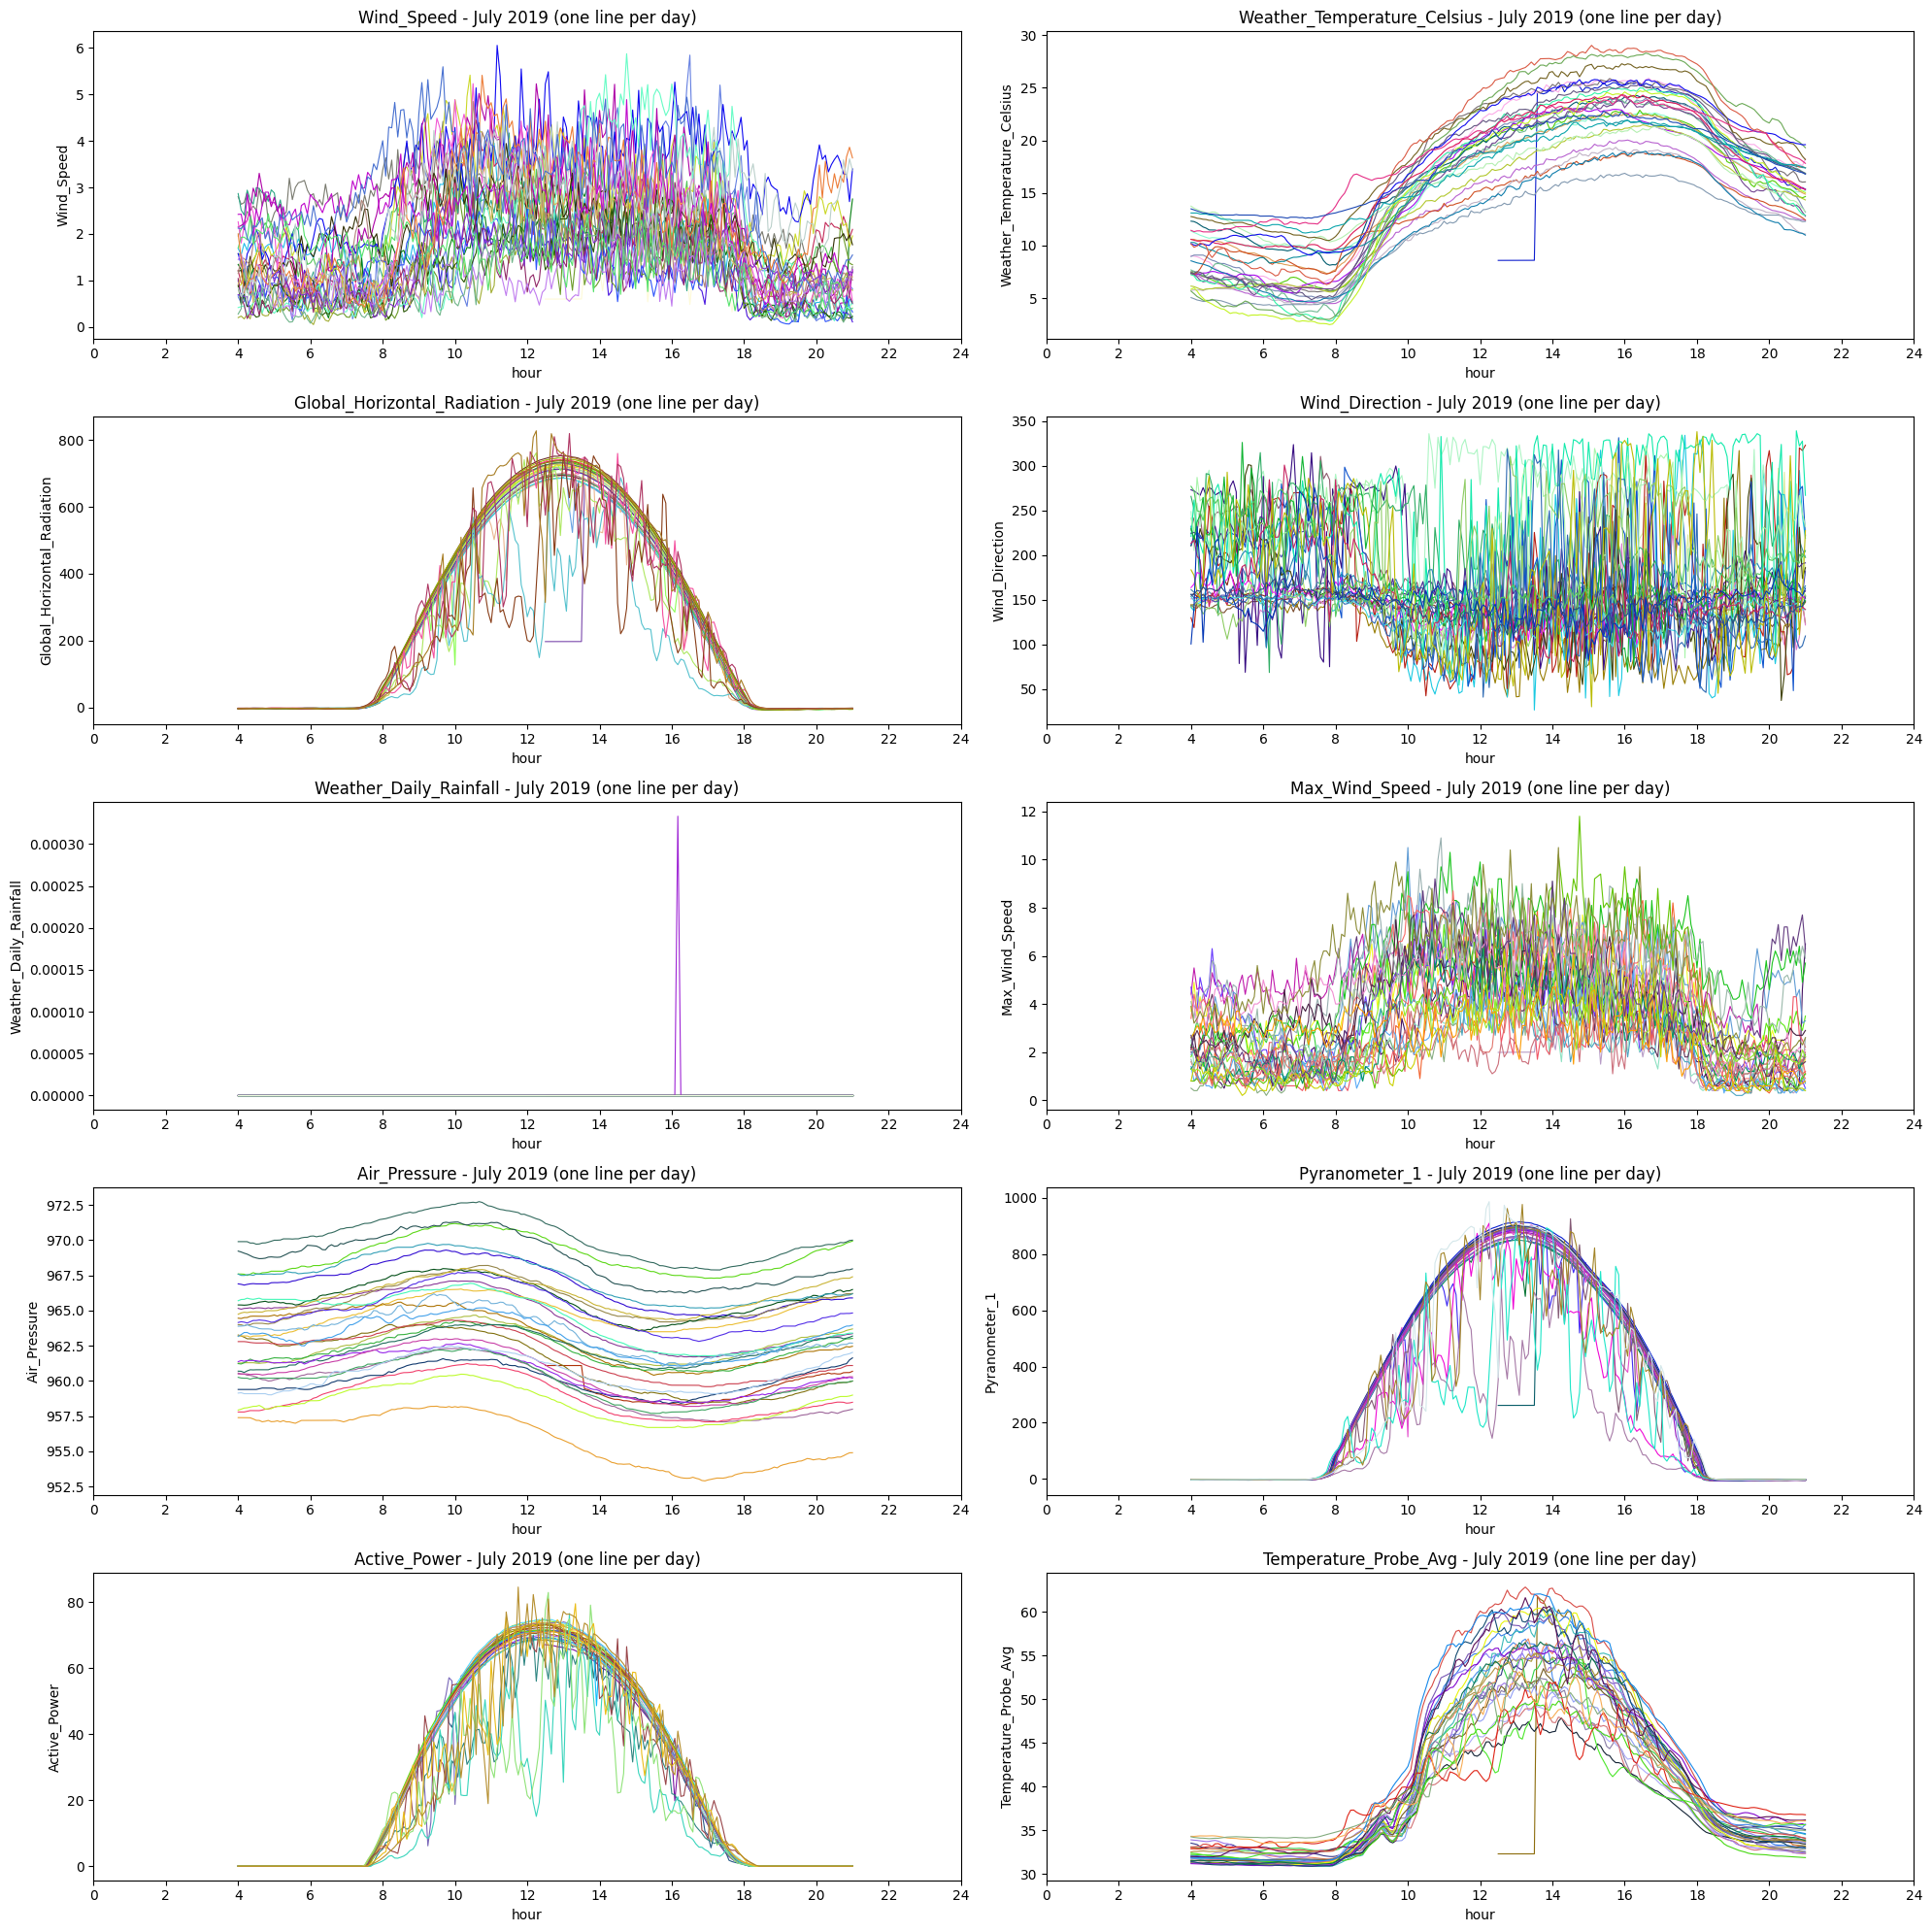

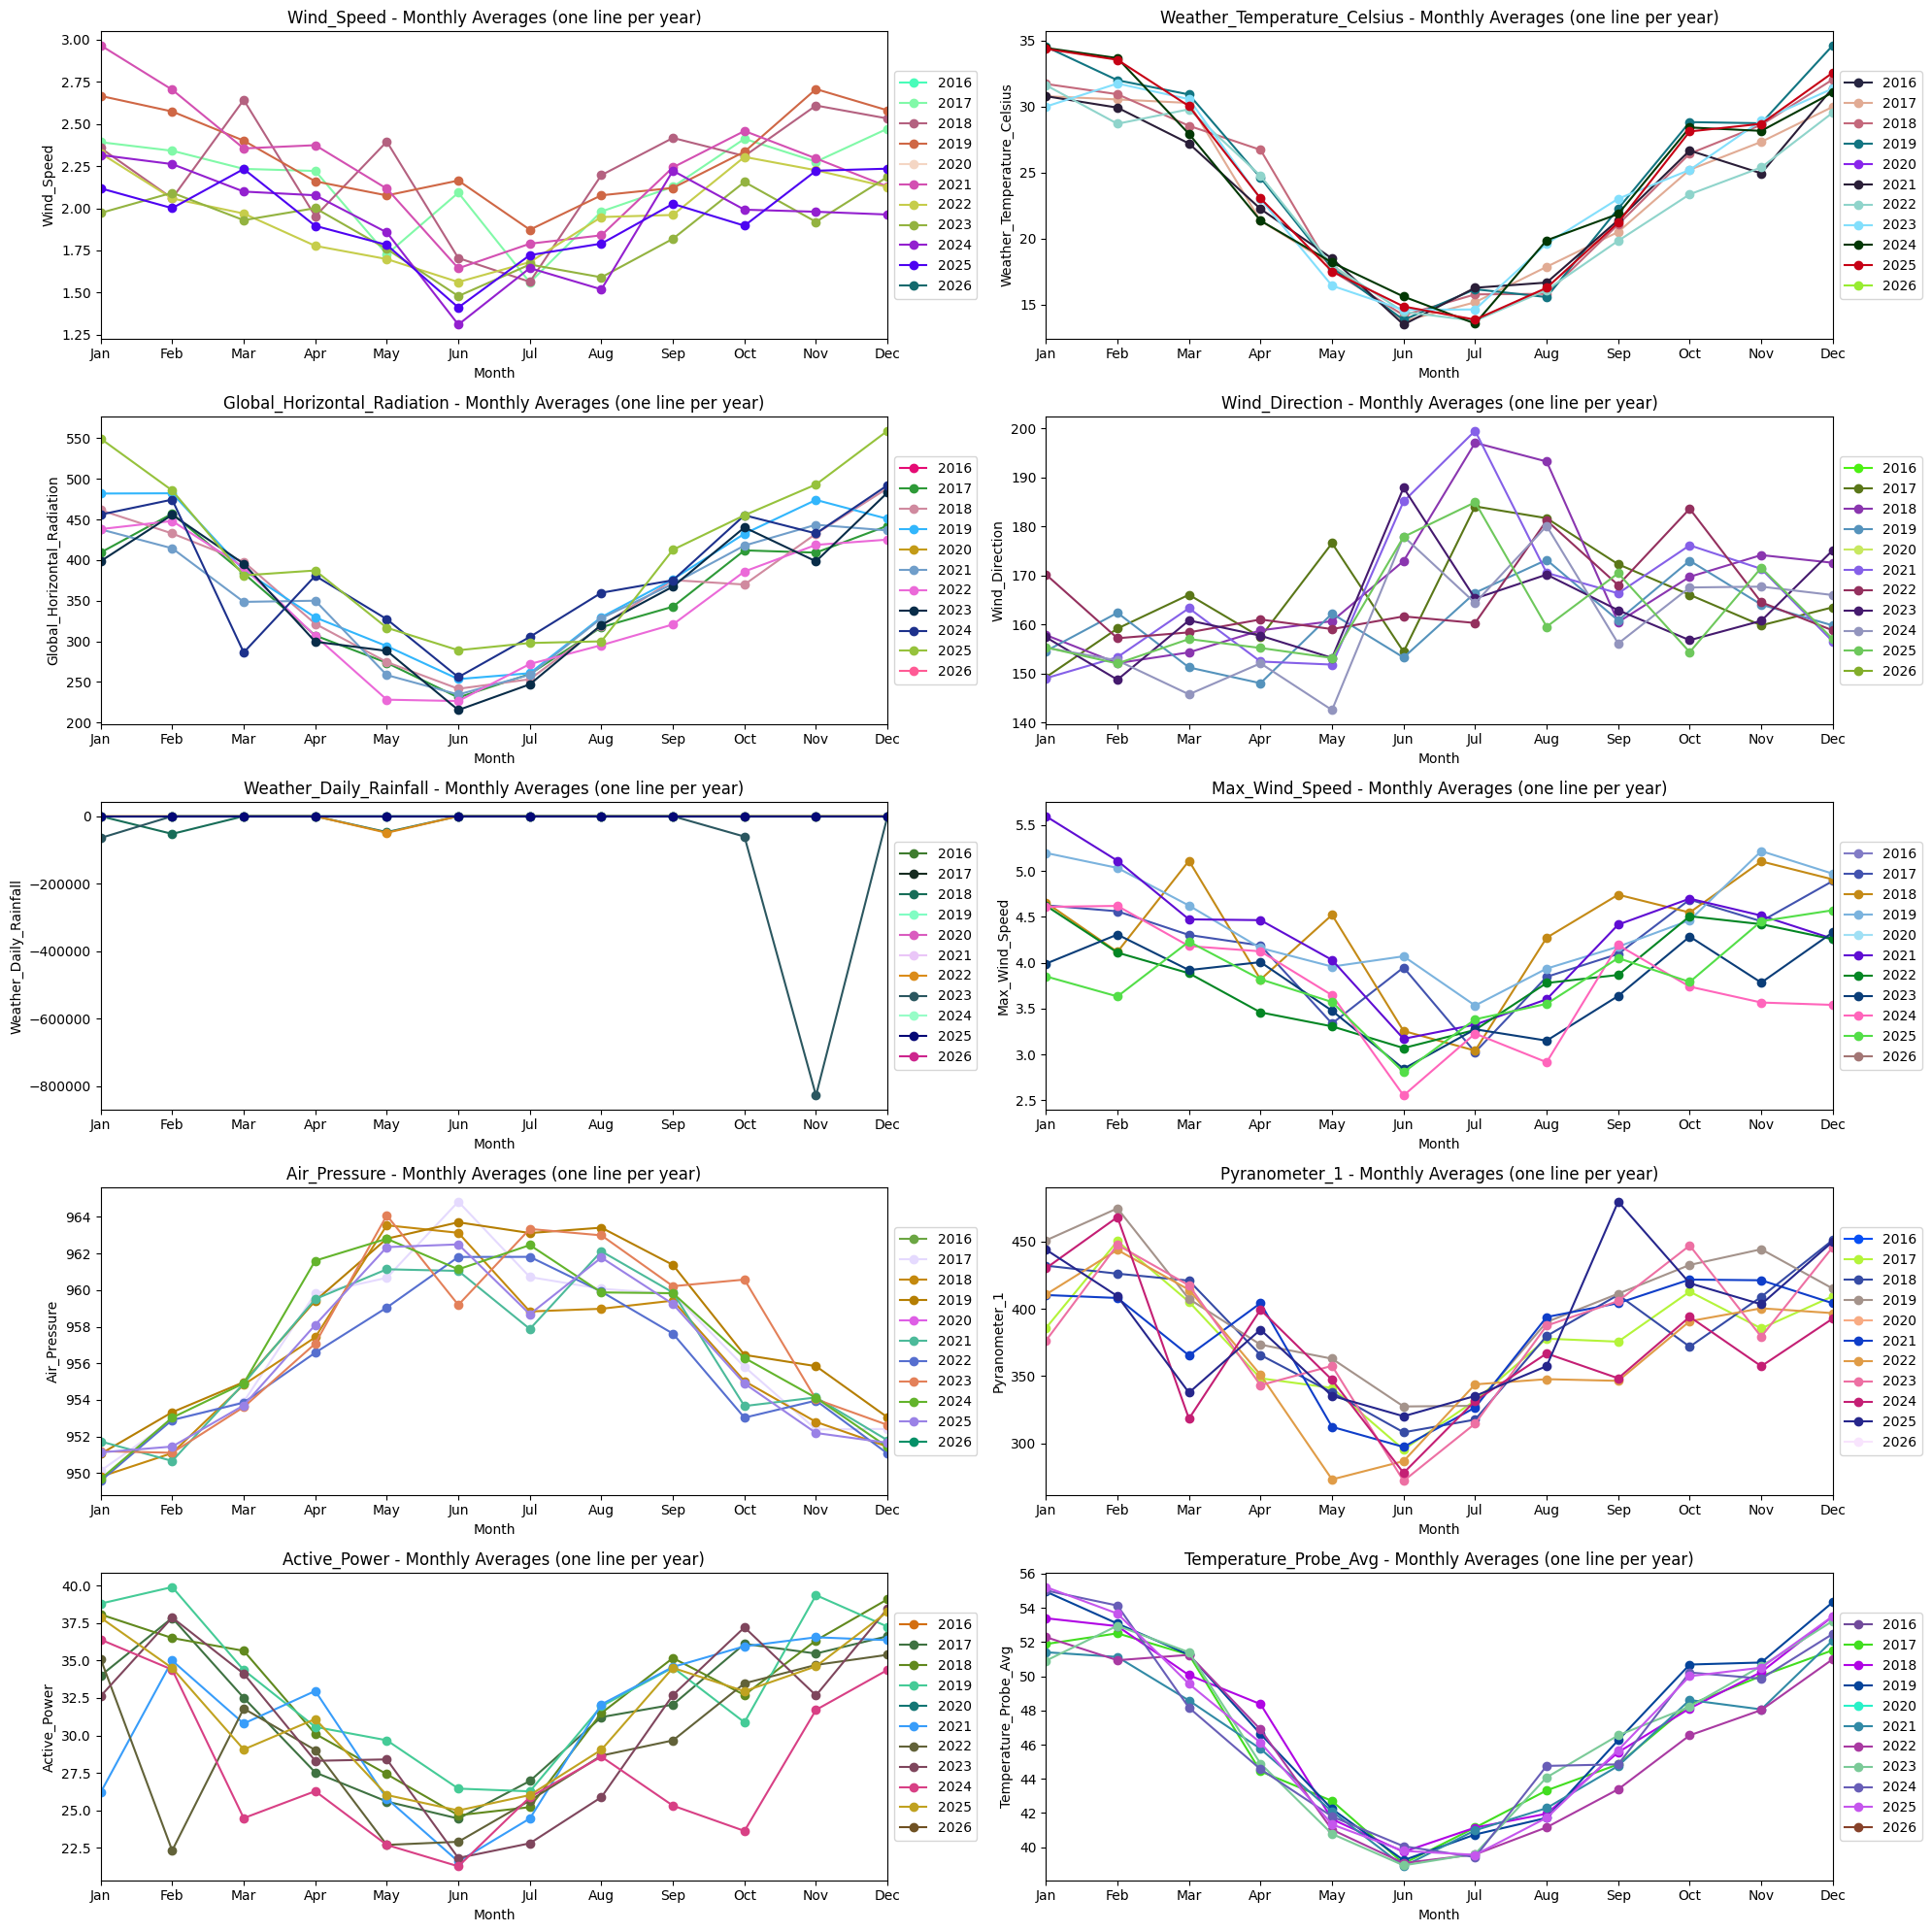

In [ ]:
# Exploratory Data Analysis: Temporal Pattern Visualization
# Generate visualizations to understand daily and seasonal patterns in sensor data.
# Helps identify anomalies and inform feature engineering decisions.
#
# Visualization 1: Daily Patterns (July 2019)
# Shows diurnal cycles for each feature: one colored line per day
# Reveals if patterns are consistent across the month

fig, axes = plt.subplots(5, 2, figsize=(20, 20))
axes = axes.flatten()

# Plot daily patterns for July 2019
for idx, col in enumerate(feature_cols + target_cols):
    for day in range(1, 32):
        day_data = df[(df['year'] == 2019) & (df['month'] == 7) &
                      (df['day'] == day)]
        axes[idx].plot(day_data['hour_of_day'],
                       day_data[col],
                       color=(random.random(), random.random(),
                              random.random()),
                       linewidth=0.8,
                       linestyle='-',
                       marker=None)
    axes[idx].set_title(f"{col} - July 2019 (one line per day)")
    axes[idx].set_xlabel("hour")
    axes[idx].set_ylabel(col)
    axes[idx].set_xlim(0, 24)
    axes[idx].set_xticks(range(0, 25, 2))

plt.tight_layout()
plt.savefig('fig_daily_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 2: Monthly Aggregates by Year
# Shows seasonal trends: one line per year with monthly averages
# Reveals inter-annual consistency and long-term patterns

fig, axes = plt.subplots(5, 2, figsize=(20, 20))
axes = axes.flatten()

for idx, col in enumerate(feature_cols + target_cols):
    for year in years:
        year_data = df[df['year'] == year]
        avg_by_month = year_data.groupby('month')[col].mean().reset_index()

        axes[idx].plot(avg_by_month['month'],
                       avg_by_month[col],
                       color=(random.random(), random.random(),
                              random.random()),
                       linewidth=1.5,
                       linestyle='-',
                       marker='o',
                       label=str(year))
    axes[idx].set_title(f"{col} - Monthly Averages (one line per year)")
    axes[idx].set_xlabel("Month")
    axes[idx].set_ylabel(col)
    axes[idx].set_xlim(1, 12)
    axes[idx].set_xticks(range(1, 13))
    axes[idx].set_xticklabels(month_names)
    axes[idx].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
# plt.savefig('fig_monthly_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Feature Engineering: Advanced Time Series Features
# Create domain-specific features to improve model predictive power.
# Three categories: cyclical encoding, rolling statistics, and temporal deltas.
#
# 1. Cyclical Features (sin/cos pairs):
#    - Encode circular/periodic features to preserve continuity
#    - Example: 23:59 should be close to 00:00 (both near midnight)
#    - Method: Normalize to [0, 1], apply sin/cos to get orthogonal pair
#
# 2. Rolling Statistics (windows: 6, 12, 24 steps = 30, 60, 120 minutes):
#    - Rolling mean: Capture local trend smoothing
#    - Rolling std: Capture local volatility/cloudiness
#    - Applied to radiation sensors and temperature
#
# 3. Temporal Differences (lags: 5, 15, 30 steps = 25, 75, 150 minutes):
#    - Rate of change: Captures solar ramp rates important for grid stability
#    - Applied to radiation sensors and temperature

# Cyclical features: Encode periodic features as sin/cos pairs
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
df['year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['wind_dir_sin'] = np.sin(2 * np.pi * df['Wind_Direction'] / 360)
df['wind_dir_cos'] = np.cos(2 * np.pi * df['Wind_Direction'] / 360)

# Rolling statistics: Multiple window sizes to capture different timescales
roll_windows = [6, 12, 24]  # 30 min, 60 min, 120 min windows

for window in roll_windows:
    # Global Horizontal Radiation rolling features
    df[f'GHI_roll_mean_{window}'] = (
        df['Global_Horizontal_Radiation'].rolling(window=window,
                                                   min_periods=1,
                                                   center=False).mean())
    df[f'GHI_roll_std_{window}'] = (
        df['Global_Horizontal_Radiation'].rolling(window=window,
                                                   min_periods=1,
                                                   center=False).std())

    # Pyranometer rolling features
    df[f'PYR_roll_mean_{window}'] = (
        df['Pyranometer_1'].rolling(window=window,
                                    min_periods=1,
                                    center=False).mean())
    df[f'PYR_roll_std_{window}'] = (
        df['Pyranometer_1'].rolling(window=window,
                                    min_periods=1,
                                    center=False).std())

    # Weather temperature rolling features
    df[f'WTC_roll_mean_{window}'] = (
        df['Weather_Temperature_Celsius'].rolling(window=window,
                                                   min_periods=1,
                                                   center=False).mean())
    df[f'WTC_roll_std_{window}'] = (
        df['Weather_Temperature_Celsius'].rolling(window=window,
                                                   min_periods=1,
                                                   center=False).std())

# Temporal differences: Capture rate of change across multiple lags
diff_windows = [5, 15, 30]  # 25 min, 75 min, 150 min lookbacks

for d in diff_windows:
    # Global Horizontal Radiation temporal difference
    df[f'GHI_diff_{d}'] = df['Global_Horizontal_Radiation'].diff(d)

    # Pyranometer temporal difference
    df[f'PYR_diff_{d}'] = df['Pyranometer_1'].diff(d)

    # Weather temperature temporal difference
    df[f'WTC_diff_{d}'] = df['Weather_Temperature_Celsius'].diff(d)

# Remove rows with NaN values from rolling/difference calculations
df = df.dropna()

In [ ]:
# Data Preparation for Modeling
# Set datetime as index and remove temporal/categorical columns no longer needed
# (used their information in feature engineering). Prepare final feature list.

# Columns Removed:
#     - timestamp: Original datetime, now in index
#     - date, time: Extracted as temporal features, redundant
#     - year, month, day: Used in filtering, encoded in features
#     - hour_of_day: Encoded as cyclical features (sin/cos)
#     - day_of_year: Encoded as cyclical features (sin/cos)

# Final Features Selected:
#     - All original and engineered features EXCEPT:
#       * Active_Power: Target variable 1
#       * Temperature_Probe_Avg: Target variable 2
#       * Wind_Direction: Used only in cyclical encoding

df = df.set_index('datetime')
df = df.drop(["timestamp", "date", "time", "year", "month", "day",
              "hour_of_day", "day_of_year"], axis=1)

# Build final feature list: all columns except targets and used-only-for-encoding
features_all = [c for c in df.columns if c not in
                ["Active_Power", "Temperature_Probe_Avg", "Wind_Direction"]]

## Modelling 

In [ ]:
# LSTM Input Preparation: Sequence Creation
# Create time-windowed sequences for LSTM model training.
# LSTM requires sequential data in [samples, time_steps, features] format.

# Sequence Parameters:
#     - lookback=24 steps: 24 * 5 min = 120 minutes (2 hours) history
#     - stride=1: Overlap consecutive sequences (improves training data)
#     - Constraint: Only include sequences with exact 2-hour gaps
#       (handles potential time series discontinuities)

# Data Normalization:
#     - MinMax scaler [0, 1] for inputs (X) and targets (y)
#     - Fit on combined data, then transform
#     - Preserves data range for inverse transformation after prediction

# Outputs:
#     - X: [num_sequences, 24, num_features]
#     - y: [num_sequences, 2] (Active_Power, Temperature_Probe_Avg)

# Extract features and targets
X_raw = df[features_all].values
y_raw = df[['Active_Power']].values

# Initialize scalers for X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform data to [0, 1] range
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# Create sequences with lookback window
lookback = 24  # 24 steps * 5 min = 120 min = 2 hours
X_seq, y_seq = [], []

for i in range(lookback, len(X_scaled)):
    # Only include sequences with exact 2-hour gaps (no data discontinuities)
    if (df.index[i] - df.index[i - lookback] == pd.Timedelta(hours=2)):
        X_seq.append(X_scaled[i - lookback:i])
        y_seq.append(y_scaled[i])

# Convert lists to numpy arrays
X = np.array(X_seq)
y = np.array(y_seq)

In [ ]:
# Data Splitting: Train/Validation/Test Sets
# Split sequential data into non-overlapping temporal partitions
# to avoid data leakage and provide realistic evaluation.

# Strategy: Sequential split (not random) to preserve temporal order
# - Training set: First 70% of sequences
# - Validation set: Next 25% of sequences (used during training)
# - Test set: Final 5% of sequences (held out for final evaluation)

# Rationale:
#     - Sequential split respects time series nature of data
#     - Test set ≈ most recent data, simulates future prediction scenario
#     - No shuffling: Preserves temporal dependencies (LSTM assumption)

train_len = int(len(X) * 0.7)
val_len = int(len(X) * 0.25)

X_train, X_val, X_test = (X[:train_len],
                          X[train_len:train_len + val_len],
                          X[train_len + val_len:])
y_train, y_val, y_test = (y[:train_len],
                          y[train_len:train_len + val_len],
                          y[train_len + val_len:])

In [ ]:
# Model Architecture: LSTM with Attention Mechanism
# Design and build a deep learning model combining CNN and LSTM layers
# with attention for improved temporal dependency learning.

# Architecture Overview:
#     Input (24 steps, 48 features)
#       ↓
#     Conv1D (32 filters, kernel=3) → Extract local temporal patterns
#       ↓
#     Dropout (0.3) → Prevent overfitting
#       ↓
#     LSTM (128 units, return_sequences=True) → Learn long-range dependencies
#       ↓
#     Dropout (0.3)
#       ↓
#     Attention Layer → Learn temporal importance weights
#       ↓
#     LSTM (64 units) → Further sequence compression
#       ↓
#     Dropout (0.3)
#       ↓
#     Dense (16 units, ReLU) → Non-linear feature extraction
#       ↓
#     Dense (8 units, ReLU) → Final compression
#       ↓
#     Dense (2 units) → Output: [Active_Power, Temperature_Probe_Avg]

# Design Rationale:
#     - Conv1D: Captures local temporal patterns (cloud shadows, etc.)
#     - LSTM: Learns long-range dependencies in sensor data
#     - Attention: Learns which historical time steps matter most
#     - Dropout: Regularization to prevent overfitting on limited data
#     - Multi-layer Dense: Non-linear feature combination

# Build model using functional API (allows attention layer integration)
inputs = Input(shape=(lookback, len(features_all)))

# Convolutional feature extraction layer
x = Conv1D(filters=32, kernel_size=3, activation='relu',
           padding='same')(inputs)
x = Dropout(0.3)(x)

# First LSTM layer: Return sequences for attention
x = LSTM(128, return_sequences=True)(x)
x = Dropout(0.3)(x)

# Attention mechanism: Learn temporal importance
attention_layer = Attention(use_scale=True)
x = attention_layer([x, x])

# Second LSTM layer: Final sequence compression
x = LSTM(64)(x)
x = Dropout(0.3)(x)

# Fully connected layers: Feature extraction and output
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)

# Output layer: Predict 2 targets (multi-output regression)
outputs = Dense(2)(x)

In [ ]:
# Model Compilation and Training Configuration
# Compile model with optimizer, loss function, and metrics.
# Configure callbacks for early stopping and training logging.

# Compilation Parameters:
#     - Optimizer: Adam (learning_rate=0.0005)
#       * Adaptive learning rate: Reduces manual tuning
#       * Lower LR: Slower convergence, better fine-tuning
#     - Loss: Mean Squared Error (MSE)
#       * Appropriate for continuous value regression
#       * Penalizes large errors quadratically
#     - Metrics: Mean Absolute Error (MAE)
#       * Interpretable in physical units (kW, °C)

# Callbacks:
#     - EarlyStopping: Stop if val_loss doesn't improve for 7 epochs
#       * Prevents overfitting by halting training early
#       * Restores weights from best epoch
#     - CSVLogger: Log epoch metrics to CSV for analysis
#       * Tracks loss, MAE for train and validation sets
#       * Enables post-training analysis and visualization

model2 = Model(inputs=inputs, outputs=outputs)

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

# Display model architecture
model2.summary()

# Early stopping callback: Stop if validation loss plateaus
early_stop = EarlyStopping(monitor='val_loss', patience=7,
                           restore_best_weights=True)

# CSV logger callback: Save epoch metrics for later analysis
csv_logger = CSVLogger('training_log_model2.csv')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 40)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 32)    │      3,872 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 32)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 128)   │     82,432 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 128)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 128)   │          1 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      1,040 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │        136 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │         18 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 136,907 (534.79 KB)

 Trainable params: 136,907 (534.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model Training
# Train the LSTM-Attention model on training data with validation monitoring.

# Training Parameters:
#     - Epochs: Maximum 200 (early stopping will likely terminate earlier)
#     - Batch size: 64 sequences per gradient update
#     - Shuffle: False (preserve temporal order for time series)
#     - Validation data: Used for early stopping and monitoring
#     - Verbose: 1 (print progress per epoch)

# Expected Process:
#     - First ~20 epochs: Rapid loss decrease as model learns patterns
#     - Middle epochs: Gradual improvement on validation set
#     - Later epochs: Early stopping when validation loss plateaus
#       (patience=7 means stop if no improvement for 7 consecutive epochs)

history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    shuffle=False,
    callbacks=[early_stop, csv_logger],
    verbose=1
)

# Visualization: Training History
# Plot training and validation loss across epochs to diagnose learning

plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('fig_model_loss_temp.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Model Evaluation and Performance Analysis
# Evaluate the trained model on held-out test set.
# Generate performance metrics and visualization plots.

# Evaluation Steps:
#     1. Make predictions on test set (scaled 0-1 range)
#     2. Inverse transform predictions and actuals to original units
#     3. Compute performance metrics (MAE, RMSE, R²) for both outputs
#     4. Save model and metrics for later use
#     5. Visualize predictions vs. actuals for diagnostic inspection

# Output 1 (Column 0): Active_Power (current forecast)
# Output 2 (Column 1): Temperature_Probe_Avg (future forecast, 30 min ahead)

# Metrics:
#     - MAE: Mean Absolute Error (interpretable as average error in original units)
#     - RMSE: Root Mean Squared Error (penalizes larger errors)
#     - R²: Coefficient of determination (0=poor, 1=perfect)

# Generate predictions on test set
y_pred_scaled = model2.predict(X_test)

# Inverse transform: Convert from [0, 1] back to original units
y_pred_current = scaler_y.inverse_transform(y_pred_scaled[:, 0:1])
y_pred_30min = scaler_y.inverse_transform(y_pred_scaled[:, 1:2])

y_test_current = scaler_y.inverse_transform(y_test[:, 0:1])
y_test_30min = scaler_y.inverse_transform(y_test[:, 1:2])

# Compute performance metrics for current forecast
mae_current = mean_absolute_error(y_test_current, y_pred_current)
rmse_current = np.sqrt(mean_squared_error(y_test_current, y_pred_current))
r2_current = r2_score(y_test_current, y_pred_current)

# Compute performance metrics for 30-minute ahead forecast
mae_30min = mean_absolute_error(y_test_30min, y_pred_30min)
rmse_30min = np.sqrt(mean_squared_error(y_test_30min, y_pred_30min))
r2_30min = r2_score(y_test_30min, y_pred_30min)

# Save trained model for future inference
model2.save('model_temp_forecast.keras')

# Compile metrics into dataframe and save to CSV
metrics2_df = pd.DataFrame({
    'Timeframe': ['Current', 'Current', 'Current',
                  '30 Minutes In the Future',
                  '30 Minutes In the Future',
                  '30 Minutes In the Future'],
    'Metric': ['MAE', 'RMSE', 'R²', 'MAE', 'RMSE', 'R²'],
    'Value': [mae_current, rmse_current, r2_current,
              mae_30min, rmse_30min, r2_30min]
})

# Save metrics to CSV
metrics2_df.to_csv('model2_metrics.csv', index=False)
print(metrics2_df)

# Visualization 1: Current Forecast vs Actuals
# Select random 288-step window (24 hours at 5-min resolution) for inspection
sample_point = random.randint(288, 10000)

plt.figure(figsize=(14, 6))
plt.plot(y_test_current[(sample_point-288):sample_point],
         label='Panel Temperature (Actual)',
         linewidth=1.5)
plt.plot(y_pred_current[(sample_point-288):sample_point],
         label='Predicted Panel Temperature (Current)',
         linewidth=1.5)
plt.title('Panel Temperature Prediction: Current Forecast')
plt.xlabel('Time steps (5-minute intervals)')
plt.ylabel('Panel Temperature (°C)')
plt.legend()
plt.grid(True)
# plt.savefig('fig_model_fit_temp_1.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 2: 30-Minute Ahead Forecast vs Actuals
# Shows model's ability to predict future temperature trends

plt.figure(figsize=(14, 6))
plt.plot(y_test_30min[(sample_point-288):sample_point],
         label='Panel Temperature 30 Minutes in Future (Actual)',
         linewidth=1.5)
plt.plot(y_pred_30min[(sample_point-288):sample_point],
         label='Predicted Panel Temperature (30 Min Ahead)',
         linewidth=1.5)
plt.title('Panel Temperature Prediction: 30-Minute Forward Forecast')
plt.xlabel('Time steps (5-minute intervals)')
plt.ylabel('Panel Temperature (°C)')
plt.legend()
plt.grid(True)
plt.savefig('fig_model_fit_temp_30_1.png', dpi=300, bbox_inches='tight')
plt.show()